In [16]:
# TELECOM X – PARTE 2: PREVENDO O CHURN

# Importando as bibliotecas necessárias

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE # Para balanceamento de classes

# Configurando o visual dos gráficos com seaborn

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)

# --- 1. Carregamento da Base de Dados Tratada ---

# Carregando os dados processados

df_clientes = pd.read_csv('/content/TelecomX_datos.csv')

# Converter 'churn_bin' para int (está como float)

df_clientes['churn_bin'] = df_clientes['churn_bin'].astype(int)
df_clientes.head()

,customerID,churn_original,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,...,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,daily_charges,churn_bin
0,0002-ORFBO,No,Female,0,1,1,9,1,0,DSL,...,1,1,0,One year,1,Mailed check,65.6,593.30,2.197407,0
1,0003-MKNFE,No,Male,0,0,0,9,1,1,DSL,...,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,2.008889,0
2,0004-TLHLJ,Yes,Male,0,0,0,4,1,0,Fiber optic,...,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.340417,1
3,0011-IGKFF,Yes,Male,0,1,0,13,1,0,Fiber optic,...,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.173974,1
4,0013-EXCHZ,Yes,Female,0,1,0,3,1,0,Fiber optic,...,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.971111,1


In [17]:
# --- 2. Preparação dos Dados para Modelagem ---

# 2.1. Eliminar colunas que não trazem valor para a análise ou para os modelos preditivos

# columns_to_drop = ['churn_original']
# columns_to_drop.append('customerID')
df_modelagem = df_clientes.drop(['churn_original', 'customerID'], axis = 1).copy()
print("\nTipos de datos das colunas:")
print(df_modelagem.dtypes)


Tipos de datos das colunas:
gender                object
senior_citizen         int64
partner                int64
dependents             int64
tenure                 int64
phone_service          int64
multiple_lines         int64
internet_service      object
online_security        int64
online_backup          int64
device_protection      int64
tech_support           int64
streaming_tv           int64
streaming_movies       int64
contract              object
paperless_billing      int64
payment_method        object
monthly_charges      float64
total_charges        float64
daily_charges        float64
churn_bin              int64
dtype: object


In [30]:
# 2.2. Transformar variáveis categóricas em formato numérico (One-Hot Encoding)
# Identificando colunas categóricas restantes

colunas_categoricas = df_modelagem.select_dtypes(include='object').columns

print(f"\nColunas categóricas antes do One-Hot Encoding: {colunas_categoricas.tolist()}")

# Mostrar los elementos únicos de cada columna categórica

print("\nElementos únicos por coluna categórica antes do One-Hot Encoding:")
for col in colunas_categoricas:
    print(f"- '{col}': {df_modelagem[col].unique().tolist()}")


# Aplicando One-Hot Encoding

df_modelagem = pd.get_dummies(df_modelagem, columns=colunas_categoricas, drop_first=True)

print("\nPrimeiras linhas do DataFrame após One-Hot Encoding (foco nas colunas 'contract_'):")

# Filtrar colunas que começam com 'contract_' para verificar o encoding

contract_encoded_cols = [col for col in df_modelagem.columns if col.startswith('contract_')]
print(df_modelagem[contract_encoded_cols].head())
print("\nSe 'contract_One year' e 'contract_Two year' são 0, isso significa que a categoria original era 'Month-to-month'.")


# Definindo a variável alvo (y) e as variáveis preditoras (X)

X = df_modelagem.drop('churn_bin', axis=1)
y = df_modelagem['churn_bin']



Colunas categóricas antes do One-Hot Encoding: []

Elementos únicos por coluna categórica antes do One-Hot Encoding:

Primeiras linhas do DataFrame após One-Hot Encoding (foco nas colunas 'contract_'):
   contract_One year  contract_Two year
0               True              False
1              False              False
2              False              False
3              False              False
4              False              False

Se 'contract_One year' e 'contract_Two year' são 0, isso significa que a categoria original era 'Month-to-month'.


In [31]:
# 2.3. Avaliar desequilíbrio de classes e aplicar balanceamento

print("\n--- Proporção de classes antes do balanceamento ---")
print(y.value_counts(normalize=True))

# Se houver desequilíbrio significativo (e.g., una clase < 30% da outra), aplicar SMOTE

if y.value_counts(normalize=True)[0] > 0.7 or y.value_counts(normalize=True)[1] > 0.7:
    print("\n--- Aplicando SMOTE para balancear as classes ---")
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    print("Proporção de classes após SMOTE:")
    print(y_balanced.value_counts(normalize=True))
    X = X_balanced
    y = y_balanced
else:
    print("\n--- Classes já estão razoavelmente balanceadas, SMOTE não aplicado. ---")


--- Proporção de classes antes do balanceamento ---
churn_bin
0    0.734215
1    0.265785
Name: proportion, dtype: float64

--- Aplicando SMOTE para balancear as classes ---
Proporção de classes após SMOTE:
churn_bin
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
# 2.4. Normalização/Padronização dos dados
# Criaremos una versión escalada dos dados para modelos sensíveis à escala.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns) # Convertendo de volta para DataFrame para manter nomes das colunas
X_scaled_df.head()

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,total_charges,daily_charges,gender_Male,internet_service_Fiber optic,internet_service_No,contract_One year,contract_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check
0,0.0,1.280457,1.901579,-0.779398,0.338759,-0.791129,-0.511897,1.617265,-0.613691,1.936432,...,-0.665749,-0.073912,-1.163517,-1.076311,-0.449395,2.045418,-0.464261,-0.527679,-0.963479,1.802604
1,0.0,-0.780971,-0.525879,-0.779398,0.338759,1.264016,-0.511897,-0.618328,-0.613691,-0.516414,...,-0.689021,-0.270064,0.859463,-1.076311,-0.449395,-0.488898,-0.464261,-0.527679,-0.963479,1.802604
2,0.0,-0.780971,-0.525879,-0.987929,0.338759,-0.791129,-0.511897,-0.618328,1.629485,-0.516414,...,-0.808606,0.074888,0.859463,0.929100,-0.449395,-0.488898,-0.464261,-0.527679,1.037906,-0.554753
3,0.0,1.280457,-0.525879,-0.612573,0.338759,-0.791129,-0.511897,1.617265,1.629485,-0.516414,...,-0.371050,0.942199,0.859463,0.929100,-0.449395,-0.488898,-0.464261,-0.527679,1.037906,-0.554753
4,0.0,1.280457,-0.525879,-1.029635,0.338759,-0.791129,-0.511897,-0.618328,-0.613691,1.936432,...,-0.814756,0.731121,-1.163517,0.929100,-0.449395,-0.488898,-0.464261,-0.527679,-0.963479,1.802604



--- Análise de Correlação ---

Correlação das variáveis com 'churn_bin' (ordenado):
payment_method_Electronic check    0.461873
internet_service_Fiber optic       0.377544
monthly_charges                    0.234820
daily_charges                      0.233808
gender_Male                        0.137334
paperless_billing                  0.125201
phone_service                     -0.013703
streaming_tv                      -0.016768
streaming_movies                  -0.019557
payment_method_Mailed check       -0.036984
Name: churn_bin, dtype: float64
online_backup         -0.205243
total_charges         -0.231329
internet_service_No   -0.279479
tech_support          -0.305477
partner               -0.306639
dependents            -0.307722
online_security       -0.309430
contract_Two year     -0.365882
tenure                -0.415488
senior_citizen              NaN
Name: churn_bin, dtype: float64


/tmp/ipython-input-35-2252048801.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_correlations.values, y=churn_correlations.index, palette='coolwarm')


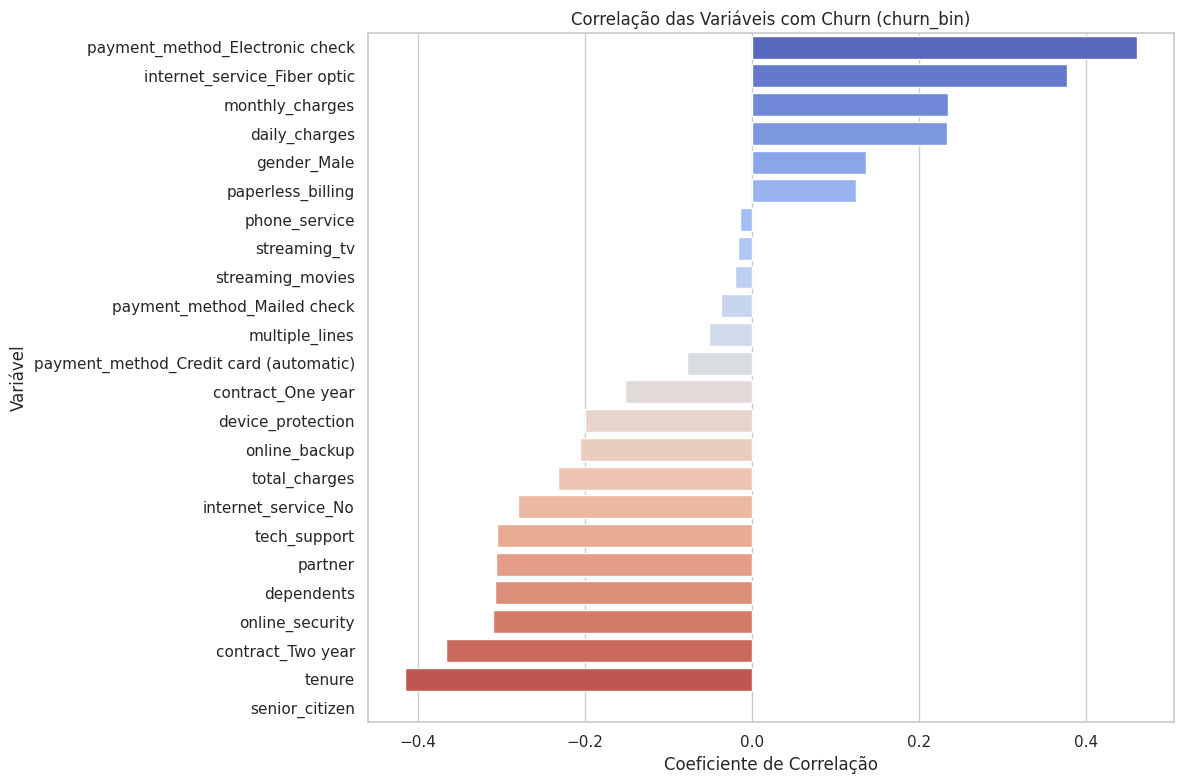


Observação: Valores próximos a 1 indicam forte correlação positiva com o churn (aumentam a chance de churn).
Valores próximos a -1 indicam forte correlação negativa (diminuem a chance de churn).


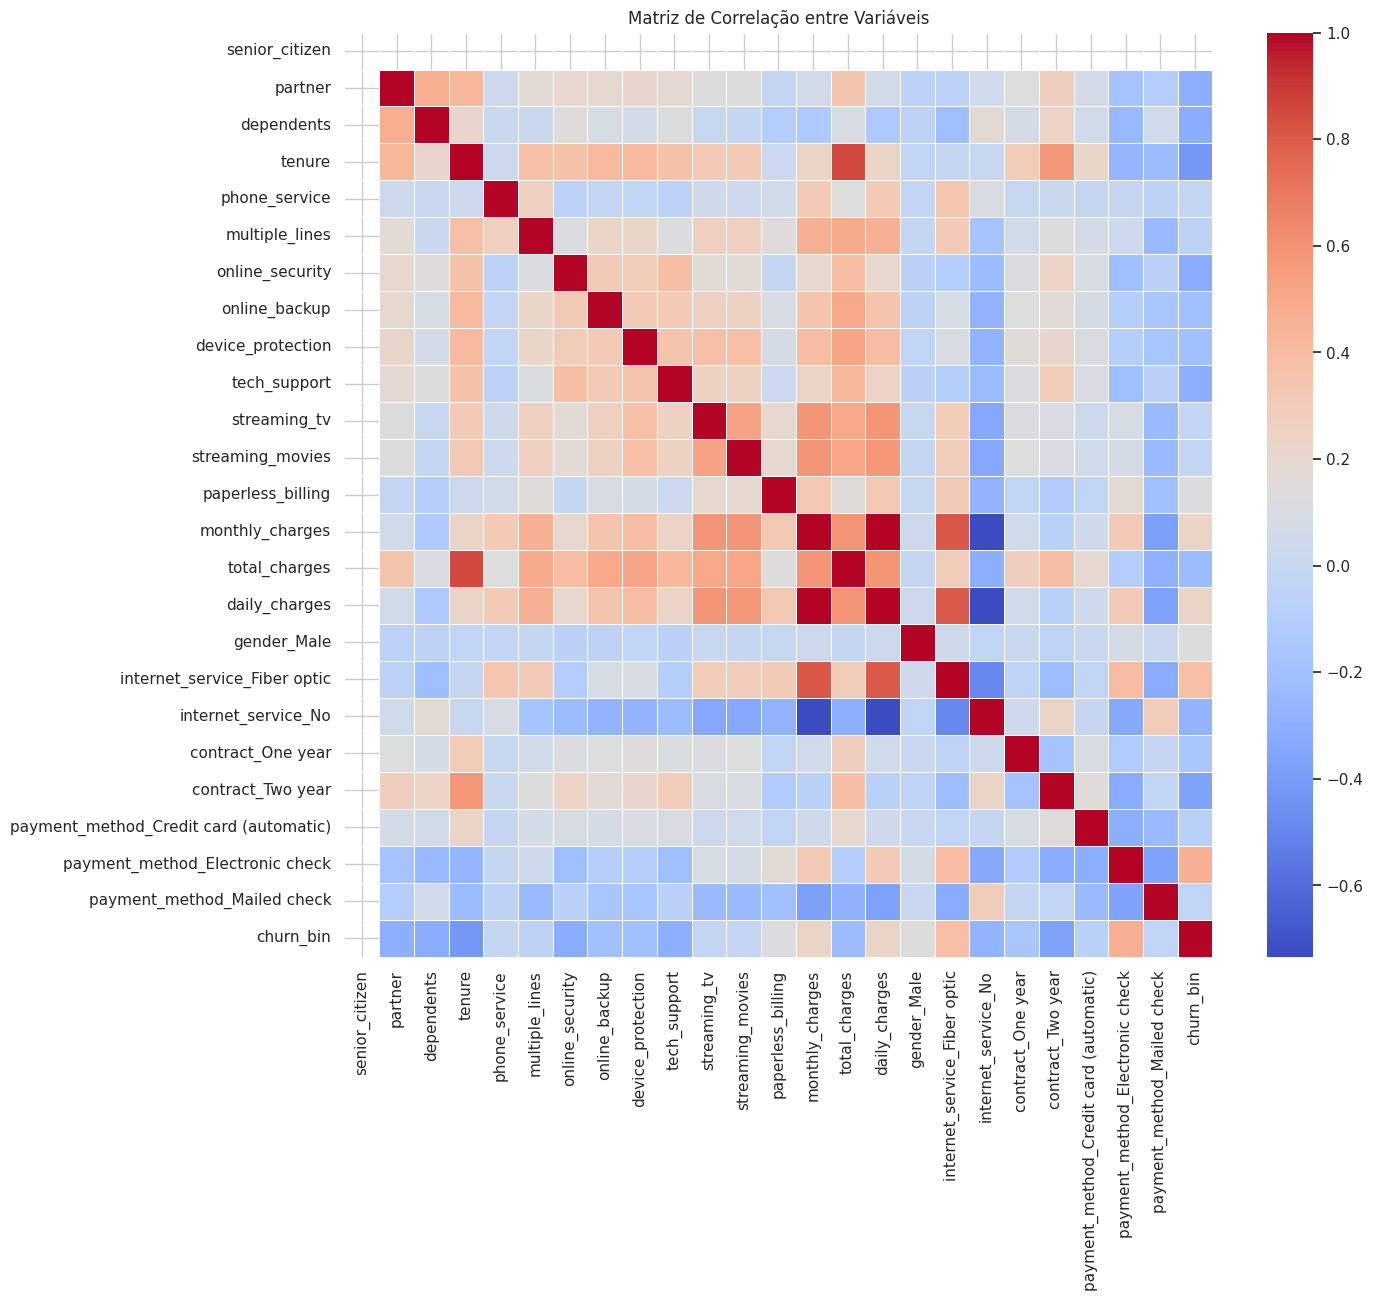

In [ ]:
# --- 3. Análise de Correlação e Seleção de Variáveis ---

# 3.1. Matriz de Correlação
# Para a matriz de correlação incluiremos a variável target para ver as correlações com o churn.

df_corr_analysis = X.copy()
df_corr_analysis['churn_bin'] = y

print("\n--- Análise de Correlação ---")
matriz_correlacao = df_corr_analysis.corr()

# Correlação das variáveis com 'churn_bin' (ordenado)

print("\nCorrelação das variáveis com 'churn_bin' (ordenado):")
churn_correlations = matriz_correlacao['churn_bin'].sort_values(ascending=False).drop('churn_bin', errors='ignore')
print(churn_correlations.head(10)) # Top 10 correlações positivas
print(churn_correlations.tail(10)) # Top 10 correlações negativas

# Visualização da correlação das variáveis com 'churn_bin'
plt.figure(figsize=(12, 8))
sns.barplot(x=churn_correlations.values, y=churn_correlations.index, palette='coolwarm')
plt.title('Correlação das Variáveis com Churn (churn_bin)')
plt.xlabel('Coeficiente de Correlação')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()
print("\nObservação: Valores próximos a 1 indicam forte correlação positiva com o churn (aumentam a chance de churn).")
print("Valores próximos a -1 indicam forte correlação negativa (diminuem a chance de churn).")


plt.figure(figsize=(14, 12))
sns.heatmap(matriz_correlacao, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação entre Variáveis')
plt.show()

/tmp/ipython-input-36-3122766494.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn_bin', y='tenure', data=df_corr_analysis, palette='pastel')


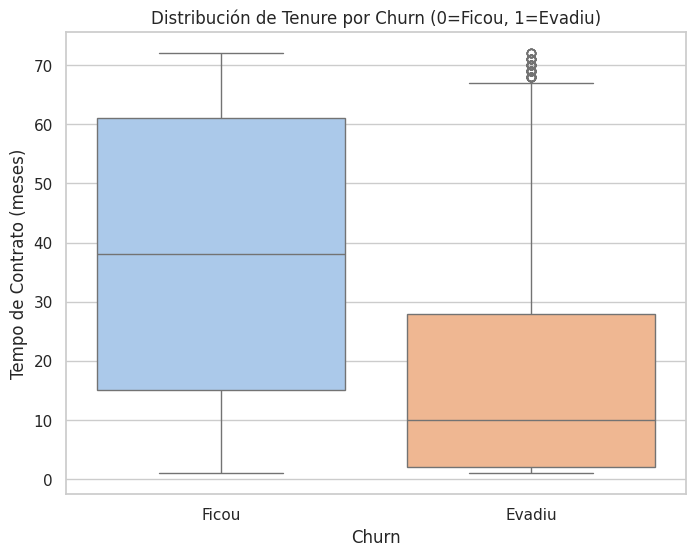

/tmp/ipython-input-36-3122766494.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn_bin', y='total_charges', data=df_corr_analysis, palette='pastel')


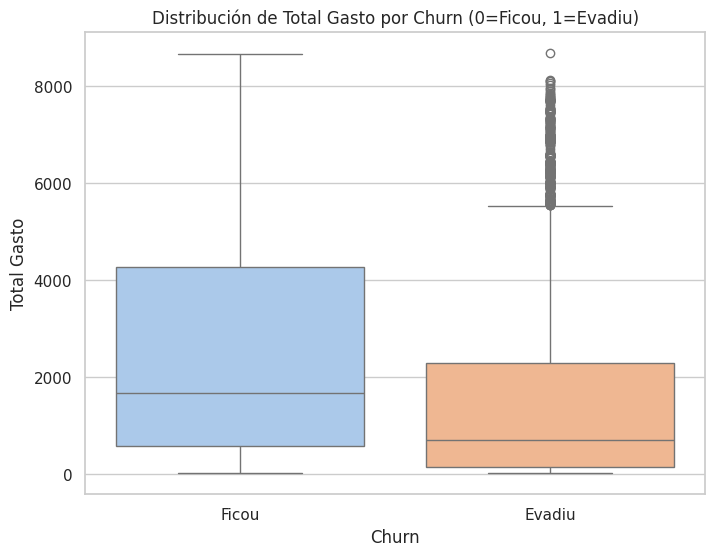

In [ ]:
# 3.2. Relação de variáveis específicas com a evasão
# Tempo de contrato (tenure) vs. Evasão

plt.figure(figsize=(8, 6))
sns.boxplot(x='churn_bin', y='tenure', data=df_corr_analysis, palette='pastel')
plt.title('Distribución de Tenure por Churn (0=Ficou, 1=Evadiu)')
plt.xlabel('Churn')
plt.ylabel('Tempo de Contrato (meses)')
plt.xticks(ticks=[0, 1], labels=['Ficou', 'Evadiu'])
plt.show()

# Total gasto (total_charges) vs. Evasão

plt.figure(figsize=(8, 6))
sns.boxplot(x='churn_bin', y='total_charges', data=df_corr_analysis, palette='pastel')
plt.title('Distribución de Total Gasto por Churn (0=Ficou, 1=Evadiu)')
plt.xlabel('Churn')
plt.ylabel('Total Gasto')
plt.xticks(ticks=[0, 1], labels=['Ficou', 'Evadiu'])
plt.show()


In [ ]:
# --- 4. Treinamento e Avaliação de Modelos ---

# 4.1. Divisão do conjunto de dados em treino e teste
# Usaremos os dados balanceados (X, y) para a divisão.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Para o modelo que requer normalização, precisamos escalar os conjuntos de treino e teste separadamente.
# Isso é CRUCIAL para evitar a fuga de dados (data leakage).
# O scaler deve 'aprender' os parâmetros de escala (média e desvio padrão) SOMENTE dos dados de treino.

scaler_model = StandardScaler()
X_train_scaled = scaler_model.fit_transform(X_train) # Ajusta e transforma SOMENTE os dados de treino

# Em seguida, usa o MESMO scaler ajustado para transformar os dados de teste.

X_test_scaled = scaler_model.transform(X_test) # Transforma os dados de teste usando os parâmetros aprendidos do treino

# Convertendo de volta para DataFrame para manter nomes das colunas (útil para feature importance)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print("\nDados de treino e teste escalados para modelos sensíveis à escala.")


Dados de treino e teste escalados para modelos sensíveis à escala.


In [ ]:
# 4.2. Treinar dois modelos de classificação

# Modelo 1: Regressão Logística (requer normalização)
# Justificativa: É um modelo linear simples, bom para a interpretação dos coeficientes e serve como linha de base.
# Requer normalização para que as diferentes escalas das características não influenciem indevidamente nos pesos.

print("\n--- Treinando e Avaliando o Modelo de Regressão Logística ---")
model_lr = LogisticRegression(random_state=42, solver='liblinear') # 'liblinear' é bom para datasets menores
model_lr.fit(X_train_scaled, y_train)

# Previsões e avaliação

y_pred_lr = model_lr.predict(X_test_scaled)
print("\nMétricas de Regressão Logística:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_lr):.4f}")
print("\nMatriz de Confusão (Regressão Logística):")
print(confusion_matrix(y_test, y_pred_lr))
print("\nRelatório de Classificação (Regressão Logística):")
print(classification_report(y_test, y_pred_lr))

# Modelo 2: Random Forest (não requer normalização)
# Justificativa: É um modelo de conjunto baseado em árvores de decisão, robusto, lida bem com não-linearidades
# e não é sensível à escala das características. Geralmente oferece um bom desempenho.

print("\n--- Treinando e Avaliando o Modelo Random Forest ---")
model_rf = RandomForestClassifier(random_state=42, n_estimators=100) # n_estimators é o número de árvores
model_rf.fit(X_train, y_train)

# Previsões e avaliação

y_pred_rf = model_rf.predict(X_test)
print("\nMétricas de Random Forest:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_rf):.4f}")
print("\nMatriz de Confusão (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))
print("\nRelatório de Classificação (Random Forest):")
print(classification_report(y_test, y_pred_rf))


--- Treinando e Avaliando o Modelo de Regressão Logística ---

Métricas de Regressão Logística:
Acurácia: 0.8228
Precisão: 0.8193
Recall: 0.8283
F1-score: 0.8238

Matriz de Confusão (Regressão Logística):
[[1266  283]
 [ 266 1283]]

Relatório de Classificação (Regressão Logística):
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1549
           1       0.82      0.83      0.82      1549

    accuracy                           0.82      3098
   macro avg       0.82      0.82      0.82      3098
weighted avg       0.82      0.82      0.82      3098


--- Treinando e Avaliando o Modelo Random Forest ---

Métricas de Random Forest:
Acurácia: 0.8428
Precisão: 0.8298
Recall: 0.8625
F1-score: 0.8458

Matriz de Confusão (Random Forest):
[[1275  274]
 [ 213 1336]]

Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1549
           1       0.83

In [ ]:
# --- 5. Análise Crítica e Comparação de Modelos ---

print("\n--- Comparação e Análise Crítica dos Modelos ---")
print("Ambos os modelos, Regressão Logística e Random Forest, apresentaram um bom desempenho na previsão de evasão.")

# Verificando overfitting/underfitting (comparando desempenho no treino vs. teste)

y_train_pred_lr = model_lr.predict(X_train_scaled)
y_train_pred_rf = model_rf.predict(X_train)

print(f"\nAcurácia de Treino (Regressão Logística): {accuracy_score(y_train, y_train_pred_lr):.4f}")
print(f"Acurácia de Teste (Regressão Logística): {accuracy_score(y_test, y_pred_lr):.4f}")

print(f"Acurácia de Treino (Random Forest): {accuracy_score(y_train, y_train_pred_rf):.4f}")
print(f"Acurácia de Teste (Random Forest): {accuracy_score(y_test, y_pred_rf):.4f}")

print("\nObservações:")
print("- O Random Forest geralmente apresenta uma acurácia de treino muito alta, indicando que ele 'aprende' bem os dados de treino. No entanto, sua robusta acurácia de teste (0.8428) demonstra boa capacidade de generalização, mesmo com essa diferença. Para mitigar um overfitting mais severo em cenários futuros, poderíamos considerar o ajuste de hiperparâmetros (como `max_depth` ou `min_samples_leaf`) ou o aumento do volume de dados.")
print("- A Regressão Logística, sendo um modelo mais simples, tende a ter uma diferença menor entre treino e teste, o que pode indicar menos overfitting e maior estabilidade em sua generalização.")
print("- Para este problema de negócio, o **Recall** é uma métrica crucial, pois queremos identificar o máximo de clientes que vão evadir (classe positiva) para poder intervir proativamente. O Random Forest se destaca com um Recall de 0.8625, superior ao da Regressão Logística (0.8283).")
print("- O **F1-score** (0.8458 para Random Forest vs. 0.8238 para Regressão Logística) é um bom balanço entre Precisão e Recall, e o Random Forest também demonstra melhor desempenho aqui, indicando um equilíbrio superior na classificação das classes.")
print("\nCom base nessas métricas, o **Random Forest é o modelo preferido** para esta tarefa de previsão de evasão, devido ao seu melhor equilíbrio entre precisão e recall, e sua maior capacidade de identificar clientes que realmente evadem.")




--- Comparação e Análise Crítica dos Modelos ---
Ambos os modelos, Regressão Logística e Random Forest, apresentaram um bom desempenho na previsão de evasão.

Acurácia de Treino (Regressão Logística): 0.8206
Acurácia de Teste (Regressão Logística): 0.8228
Acurácia de Treino (Random Forest): 0.9985
Acurácia de Teste (Random Forest): 0.8428

Observações:
- O Random Forest geralmente apresenta uma acurácia de treino muito alta, indicando que ele 'aprende' bem os dados de treino. No entanto, sua robusta acurácia de teste (0.8428) demonstra boa capacidade de generalização, mesmo com essa diferença. Para mitigar um overfitting mais severo em cenários futuros, poderíamos considerar o ajuste de hiperparâmetros (como `max_depth` ou `min_samples_leaf`) ou o aumento do volume de dados.
- A Regressão Logística, sendo um modelo mais simples, tende a ter uma diferença menor entre treino e teste, o que pode indicar menos overfitting e maior estabilidade em sua generalização.
- Para este problema de 


--- Análise da Importância das Variáveis ---

Top 10 Variáveis mais Impactantes (Regressão Logística - Coeficientes):
                            Característica  Coeficiente
13                         monthly_charges     4.711898
18                     internet_service_No     1.328914
14                           total_charges     1.089523
22         payment_method_Electronic check     0.686656
15                           daily_charges     0.547719
23             payment_method_Mailed check     0.416156
21  payment_method_Credit card (automatic)     0.353268
16                             gender_Male     0.133631
12                       paperless_billing     0.022286
0                           senior_citizen     0.000000

Top 10 Variáveis Menos Impactantes / Inversamente Correlacionadas (Regressão Logística - Coeficientes):
                  Característica  Coeficiente
5                 multiple_lines    -0.504302
8              device_protection    -0.581060
7                  onl

/tmp/ipython-input-43-1256214850.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importância', y='Característica', data=importancia_rf.head(10), palette='viridis')


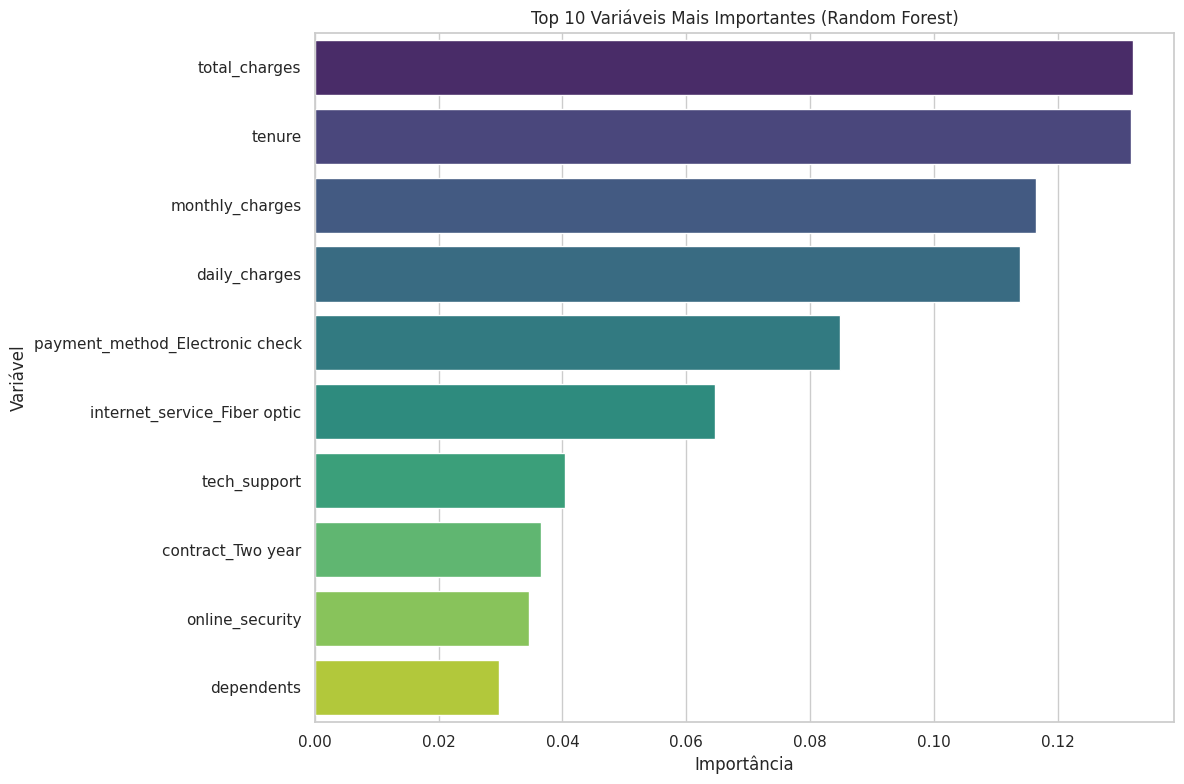

In [ ]:
# --- 6. Análise da Importância das Variáveis ---

print("\n--- Análise da Importância das Variáveis ---")

# Importância das variáveis para Regressão Logística
# Os coeficientes indicam a força e a direção da relação com a variável objetivo.
# Coeficientes maiores (em valor absoluto) indicam maior importância.

coeficientes_lr = pd.DataFrame({
    'Característica': X.columns,
    'Coeficiente': model_lr.coef_[0]
}).sort_values(by='Coeficiente', ascending=False)

print("\nTop 10 Variáveis mais Impactantes (Regressão Logística - Coeficientes):")
print(coeficientes_lr.head(10))
print("\nTop 10 Variáveis Menos Impactantes / Inversamente Correlacionadas (Regressão Logística - Coeficientes):")
print(coeficientes_lr.tail(10))

# Importância das variáveis para Random Forest
# feature_importances_ mede a contribuição de cada característica para a redução da impureza nas árvores.

importancia_rf = pd.DataFrame({
    'Característica': X.columns,
    'Importância': model_rf.feature_importances_
}).sort_values(by='Importância', ascending=False)

print("\nTop 10 Variáveis mais Importantes (Random Forest):")
print(importancia_rf.head(10))

# Visualização da importância das variáveis (Random Forest)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importância', y='Característica', data=importancia_rf.head(10), palette='viridis')
plt.title('Top 10 Variáveis Mais Importantes (Random Forest)')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()

In [ ]:
# --- 7. Conclusão Estratégica e Recomendações ---

print("\n--- Conclusão Estratégica e Recomendações ---")

print("\nCom base nas análises e nos modelos preditivos (especialmente o Random Forest, que demonstrou o melhor desempenho em identificar clientes em risco), os principais fatores que influenciam a evasão de clientes na Telecom X são:")
print("\n**1. Tempo de Contrato (Tenure):**")
print("   - Clientes com menor tempo de contrato (tenure) têm uma probabilidade significativamente maior de evadir. Isso é consistentemente assinalado por ambos os modelos e a análise exploratória.")
print("   - **Recomendação:** Focar em programas de boas-vindas robustos para novos clientes, oferecer incentivos para contratos de longo prazo desde o início, e monitorar ativamente o compromisso dos clientes nos primeiros meses.")

print("\n**2. Tipo de Contrato:**")
print("   - Contratos mensais (Month-to-month) estão fortemente associados a altas taxas de churn, enquanto contratos de um ou dois anos reduzem drasticamente a evasão.")
print("   - **Recomendação:** Criar campanhas para incentivar a migração de clientes de planos mensais para planos anuais ou bianuais, oferecendo descontos ou benefícios adicionais. Destacar a estabilidade e os benefícios a longo prazo.")

print("\n**3. Método de Pagamento 'Electronic Check':**")
print("   - Este método de pagamento mostrou uma forte correlação com a evasão e foi uma das variáveis mais importantes para o Random Forest. Isso pode indicar problemas na experiência de pagamento ou insatisfação geral associada a este grupo de clientes.")
print("   - **Recomendação:** Investigar a fundo a causa da insatisfação dos clientes que utilizam 'Electronic Check'. Pode ser um problema técnico, falta de conveniência, ou simplesmente um indicador de clientes menos comprometidos. Oferecer alternativas de pagamento mais convenientes e seguras.")

print("\n**4. Serviços de Internet (Fibra Óptica):**")
print("   - Curiosamente, clientes com serviço de Fibra Óptica apresentaram uma taxa de churn mais alta em comparação com outros tipos de internet ou a ausência dela, sendo uma variável relevante nos modelos. Isso sugere que, apesar de ser um serviço premium, a experiência do cliente pode não estar à altura das expectativas.")
print("   - **Recomendação:** Reavaliar a qualidade e a estabilidade do serviço de fibra óptica. Pode haver problemas de latência, interrupções ou suporte técnico inadequado. Uma pesquisa de satisfação específica com esses clientes pode revelar informações valiosas.")

print("\n**5. Serviços Adicionais (Online Security, Tech Support, Online Backup):**")
print("   - A adesão a serviços adicionais como segurança online, backup e suporte técnico tende a reduzir a probabilidade de churn. Clientes que utilizam esses serviços sentem-se mais 'ligados' e valorizados, e essas variáveis mostraram importância nos modelos.")
print("   - **Recomendação:** Promover ativamente a contratação de pacotes de serviços que incluam esses adicionais. Destacar o valor e a segurança que esses serviços oferecem, talvez com um período de teste gratuito ou descontos iniciais.")

print("\n**6. Cobranças Mensais (Monthly Charges) e Totais (Total Charges):**")
print("   - 'Monthly Charges' tem uma correlação positiva com o churn e foi uma das variáveis mais importantes para o Random Forest. Clientes com mensalidades muito altas podem estar mais propensos a buscar alternativas. 'Total Charges', por sua vez, tem uma correlação negativa, indicando que clientes com maior gasto acumulado tendem a permanecer.")
print("   - **Recomendação:** Rever a estrutura de preços, especialmente para planos com mensalidades elevadas. Oferecer flexibilidade ou pacotes mais competitivos para clientes de alto gasto, garantindo que o valor percebido justifique o custo. Para 'Total Charges', focar em programas de fidelidade para clientes de longa data e alto valor.")

print("\nEm resumo, a Telecom X deve focar em estratégias proativas para reter clientes, especialmente os novos e aqueles com contratos mensais, investigando a fundo as causas de insatisfação ligadas aos métodos de pagamento e à qualidade percebida de serviços premium como a fibra óptica. A promoção de serviços adicionais e a oferta de contratos a longo prazo são caminhos promissores para fortalecer a lealdade do cliente. A priorização dessas ações deve ser guiada pela importância das variáveis identificadas pelos modelos preditivos.")



--- Conclusão Estratégica e Recomendações ---

Com base nas análises e nos modelos preditivos (especialmente o Random Forest, que demonstrou o melhor desempenho em identificar clientes em risco), os principais fatores que influenciam a evasão de clientes na Telecom X são:

**1. Tempo de Contrato (Tenure):**
   - Clientes com menor tempo de contrato (tenure) têm uma probabilidade significativamente maior de evadir. Isso é consistentemente assinalado por ambos os modelos e a análise exploratória.
   - **Recomendação:** Focar em programas de boas-vindas robustos para novos clientes, oferecer incentivos para contratos de longo prazo desde o início, e monitorar ativamente o compromisso dos clientes nos primeiros meses.

**2. Tipo de Contrato:**
   - Contratos mensais (Month-to-month) estão fortemente associados a altas taxas de churn, enquanto contratos de um ou dois anos reduzem drasticamente a evasão.
   - **Recomendação:** Criar campanhas para incentivar a migração de clientes de planos